In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mwinai as mw
import corner


#Data and functions asociated with a class == atributes and methods

#Class == blueprint for creating instances

class proyect:
    """
    Clase que lee un archivo con modelos de sintesis de poblacion en formato CSV y contiene la
    funcionalidad de entrenar una red neuronal y realizar estimaciones por medio de algoritmos geneticos.
    """
    def __init__(self, data):
        try:
            self.data = pd.read_csv(data)
        except FileNotFoundError:
            print("El archivo no se ha encontrado, o el path es incorrecto.")

        
        del self.data['Unnamed: 0']
        self.data["log_age"] = np.log10(self.data["Age(yr)"])
            
        
    def entrenador(self, ANN_name,activation = 'tanh',solver = "lbfgs",saved = False):
        """
        Metodo para entrenar una red neuronal tomando los parametros fisicos que se deben de encontrar en el fichero
        csv con los modelos de síntesis de población (Masa, edad y metalicidad), arroja como output una red
        entrenada capaz de predecir fotometrías en 7 bandas distintas. 
        
        ANN_name = nombre de la red (string)
        
        activation = nombre de la función de activación con la cual se entrenará la red por default se entrena con tanh
        
        solver = solucionador de la red, por defecto emplea lbfgs (bueno para problemas regresionales).
        
        saved = boleano que indica si la red fue guardada con anterioridad, si fue de esta manera el metodo leerá la red y la muestra
                con la que se entrenó la red y hará predicción en base a esta muestra. default = False.
        """
        RM = mw.manage_RM(RM_filename = ANN_name)
        
        if saved != True or RM == 0:
            print("No hay una red pre-existente, inicializano entrenamiento...")
            X_train = self.data[["Mass (Mo)", "log_age", "Metal(Zo)"]].to_numpy()
            Y_train = self.data[['F275W', 'F336W', 'F438W', 'F555W', 'F814W', 'F547M', 'F657N']].to_numpy()
            
            
            RM = mw.manage_RM(RM_type = 'SK_ANN', X_train=X_train, y_train=Y_train,
                              scaling=True, clear_session=True, split_ratio = 0.2)
            
        
            RM.init_RM(hidden_layer_sizes = (50,50, 50), tol = 1e-6, max_iter = 2000, activation = activation,
                       solver = solver)
            print("Entrenando red {}...".format(ANN_name))
            RM.train_RM()
            print("TODO BIEN!")
            RM.predict()
            print("Guardando red y muestra de entrenamiento...")
            RM.save_RM(ANN_name, save_train = True, save_test = True)
            print("Listo!")
        
        else:
            print("Red existente, cargando red y datos de entrenamiento guardados!")
            RM.predict(scoring = True)
            print("Prediciendo...")
            print("Listo!")
        return RM
        

    def population(self, Pop_number, X_train):
        """Funcion generadora de poblacion para algoritmo genético.
        
        Entrada: Numero de individuos en una poblacion
        
        Salida: Poblacion al azar de inviduos alrededor de el rango de valores
                del espacio de parametros con el que se entreno la red neuronal
                de la funcion entrenador
        """
        param_dim = X_train.shape
        np.random.seed(0)
        pop =  X_train.min(0) + ((X_train.max(0) - X_train.min(0)) * np.random.rand(Pop_number, param_dim[-1]))
        
        
       
        return pop
    
    def model(self, ANN,population):
        ANN.set_test(population)
        ANN.predict()
        mod = ANN.pred
        return mod
    
    def fitness(self,ANN,population, goal, X_train):

        mod = self.model(ANN, population)
        X = X_train.shape[1]
        mask = ((population >= X_train.min(0)) & (population <= X_train.max(0))).sum(1) != X
        fit = -np.sum((mod[:] - goal)**2,1)
        fit[mask] = -np.inf
        return fit, mod
        

    def genetic_alg(self, pop_num, ANN, N_best, N_worst, gen_num, goal, TOL):
        
        red = ANN
        training = red.X_train_unscaled
        #Begin first population
        pop1 = self.population(pop_num, training)
        
        
        #Calculate fitness and models
        fitness_g1, params_g1= self.fitness(red, pop1, goal, training)
        
        mask = fitness_g1 < TOL
        
        #Drop all the models that doesnt match the tolerance criteria...
        fitness_g1 = fitness_g1[~mask]

        
        
        pop1 = pop1[~mask]
        #Taking little deltas for further mutations.
        var_mass = pop1[:, 0].max() - pop1[:, 0].min()
        var_age = pop1[:, 1].max() - pop1[:, 1].min()
        var_met = pop1[:, 2].max() - pop1[:, 2].min()
        all_array = np.array([pop1[:, 0], pop1[:, 1], pop1[:, 2], fitness_g1]).T
        #Sorting parameters an selection N_best parameters
        columnIndex = 3
        sortedArr = all_array[all_array[:,columnIndex].argsort()]
        for gen in range(gen_num):
            selection = np.array([sortedArr[:N_best, 0], sortedArr[:N_best, 1], sortedArr[:N_best, 2]]).T
            
            for i in range(0, len(selection)):
                #Creating new data around the distribution of values of N_best params.
                new_mass = selection[i, 0].min() + (var_mass * np.random.randn(N_worst))
                new_age = selection[i, 1].min() + (var_age * np.random.randn(N_worst))
                new_met = selection[i, 2].min() + (var_met * np.random.randn(N_worst))
                
                new_pop = np.array([new_mass, new_age, new_met]).T

                new_pop_fit, params_new = self.fitness(red, new_pop, goal, training)
                mask = new_pop_fit < TOL
                new_pop_fit = new_pop_fit[~mask]
                new_pop = new_pop[~mask]
                new_stack = np.hstack((new_pop, np.atleast_2d(new_pop_fit).T))
                all_array = np.append(all_array, new_stack, axis = 0)
        print(all_array.shape)   
        res = pd.DataFrame(all_array)
        res.rename(columns={0: 'Mass', 1: 'Age', 2: 'Met', 3:'Distance'}, inplace=True)
        return res
    
    
            
     


C:\Users\Rogelio\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


(20566, 4)


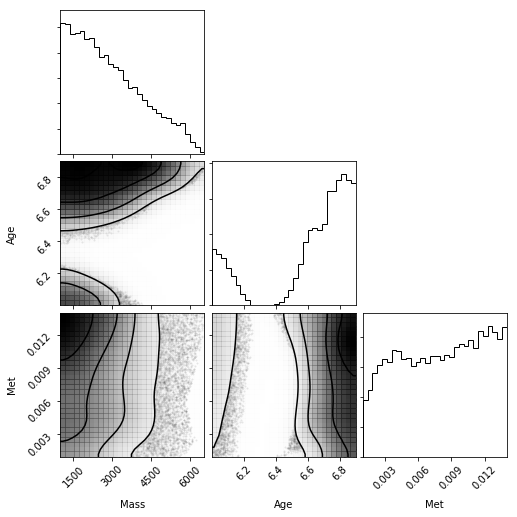

In [60]:
A = proyect('all_data_good.csv')
#%%
#red = A.entrenador('red_nueva',activation = 'tanh',solver = "adam", saved =  True)

#%%
data = pd.read_csv("NGC7793W_obs_wth_halpha")
dist_modulu = 27.68


a = data.loc[data['bst_mass'] >=  1000]
targets = a.loc[(a['bst_age'] >=  1e6) & (a['bst_age'] <=  8e6)]

targets['log_age'] = np.log10(targets['bst_age']) 

obs_1 = targets.loc[targets['ID_1'] == 513].copy()
obs_2 = targets.loc[targets['ID_1'] == 1252].copy()
target_phot = obs_1[['F275W_1', 'F336W_1', 'F438W_1', 'F555W_1', 'F814W_1', 'rw_F547M', 'rw_F657N']].to_numpy()
target_phot = target_phot - 27.68
res = A.genetic_alg(pop_num = 100000, ANN = red, N_best = 10, N_worst = 1000, gen_num = 100,goal =  target_phot, TOL = -30)

In [56]:
res

,Mass,Age,Met,Distance
0,1464.852143,6.609913,0.004510,-19.514378
1,2131.318404,6.693384,0.002910,-22.932728
2,2191.586067,6.103915,0.009040,-24.229697
3,1267.618175,6.582361,0.008805,-27.111732
4,1510.143463,6.624617,0.012954,-25.931161
...,...,...,...,...
20561,2321.895026,6.628468,0.005589,-23.065607
20562,1691.787747,6.162593,0.007544,-27.300187
20563,2882.872612,6.824738,0.001576,-14.088566
20564,1776.811130,6.831525,0.013619,-10.297978


2875.513622012647

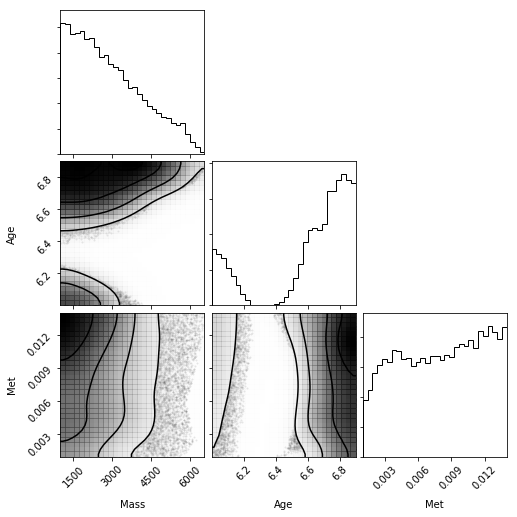

In [61]:
f = corner.corner(res[['Mass', 'Age', 'Met']], bins=30, smooth=3,plot_datapoints=True)
res['Mass'].mean()